In [1]:
import sys
from PyQt5.QtCore import QtMsgType, QMessageLogContext, qInstallMessageHandler

def messageHandler(type_, context, message):
    #if "QObject::moveToThread: Current thread is not the object's thread" not in message:
    if "QObject::moveToThread" not in message:
        # Se a mensagem não contém o aviso que deseja desativar, imprima normalmente.
        sys.__stdout__.write(message)
    else:
        # Se a mensagem contém o aviso que deseja desativar, ignore-a.
        pass

# Substitua o manipulador de mensagens padrão do PyQt ou PySide pelo nosso manipulador personalizado.
qInstallMessageHandler(messageHandler)

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import itertools
import matplotlib.pyplot as plt
import cv2
import time
import torch
import numpy as np

import math

from scipy.spatial import distance, distance_matrix
from env import make_pytorch_env

class parser:
    def __init__(self):
        self.cuda = 'store_true'
        self.device = torch.device('cuda')
        self.seed = 0 # not in use

args = parser()

env = make_pytorch_env(args)
dummy_env = make_pytorch_env(args) #TODO: use for stg

/home/gabriel/miniconda3/envs/odt/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
def nearest_neighbor(A, start):
    """Nearest neighbor algorithm.
    A is an NxN array indicating distance between N locations
    start is the index of the starting location
    Returns the path and cost of the found solution
    """
    path = [start]
    cost = 0
    N = A.shape[0]
    mask = np.ones(N, dtype=bool)  # boolean values indicating which 
                                   # locations have not been visited
    mask[start] = False

    for i in range(N-1):
        last = path[-1]
        next_ind = np.argmin(A[last][mask]) # find minimum of remaining locations
        next_loc = np.arange(N)[mask][next_ind] # convert to original location
        path.append(next_loc)
        mask[next_loc] = False
        cost += A[last, next_loc]

    return path, cost


def normalize_action(action, env):   
    # Normalzies the action between -1 and 1 after lower/highter bounding
    action = np.minimum(np.maximum(action, env.action_space.low*env.denormalize_action_factor),env.action_space.high*env.denormalize_action_factor)
    action = action/env.denormalize_action_factor
    return action

#  move_drone(env,[initial_state[0],initial_state[1],h])

def move_drone(env,desired_position):
    global action_list
    # calculate the error between the desired and current position
    dist_xy = float("inf")
    dist_h = float("inf")

    curr_xy, curr_h = env.state[:-2], env.state[-2]   
    des_xy, des_h = np.array(desired_position)[:-1], np.array(desired_position)[-1]
    
    # close feedback loop
    # proportional gain
    kp_xy, kp_h=1.0, 0.2 #0.6, 0.2 # 0.8, 0.2
    #start = time.time()
    
    # height feedback
    while(dist_h>1):
        #print(env.state[2])
        error_h = des_h-curr_h
        dist_h = distance.euclidean([des_h],[curr_h])
        # calculate the output (speed) of the controller
        speed_h = kp_h*error_h
        if dist_h>5: action = np.append([0,0],speed_h*1) # action_xy = 0
        else: action = np.append([0,0],speed_h/5)
        # Run the speed on the Env.
        action = normalize_action(action, env)
        action_list.append(action)
        next_state, _, done, _ = env.step(action)
        
        #print(done)
        curr_h = env.state[-2]
        #env.render()

    # xy feedback
    #TOOD: OBS: I tab'ed this out of the previous while!
    while(dist_xy>1):       
        error_xy = des_xy-curr_xy    
        dist_xy = distance.euclidean([des_xy],[curr_xy])
        # calculate the output (speed) of the controller
        speed_xy = kp_xy*error_xy
        if dist_xy>5: action = np.append(speed_xy*1,0) # actio_h = 0
        else: action = np.append(speed_xy/5,0)
        # Run the speed on the Env.
        
        action = normalize_action(action, env)
        action_list.append(action)
        next_state, _, done, _ = env.step(action)
        
        #print(done)
        curr_xy = env.state[:-2]      
        #env.render()
        
    #exec_time = time.time()-start
    #if exec_time>0.1: print("----> Exec. time (h): {:.2f}".format(exec_time))
        

def navigate_drone(env,mode,h=env.max_height,th=1.0):

    # mode: initial_inspection | optimize_map
    # th: threshold for map optimization
    # TODO: Implement h?
      
    initial_state = [env.state[0], env.state[1]]
    
    if mode == "initial_inspection":
        print("Initial Inpsection...")
        move_drone(env,[initial_state[0],initial_state[1],h])
    
    elif mode == "optimize_map":
        print("Optimizing Map at height: {}".format(h))
        
        
    # find all the points where the condition is met
    ys, xs = np.where(env.render_state[:,:,0]>=th)
    yx = np.stack((ys, xs), axis=1)
    # Insert the initial point
    yx = np.insert(yx, 0, initial_state,axis=0)
    # Pariwise Euclidian Distance (p=2)
    dist_m=distance_matrix(yx,yx,p=2)
    # Apply the NN algorithm to find the best path and assign it to optimal_yx
    best_state, best_fitness = nearest_neighbor(dist_m,0)    
    optimal_yx = yx[best_state]
    element = optimal_yx[0]
    last_coord = [999,999]
    h_ = h
    
    for coord in optimal_yx:
        
        # Idea: use half horizontal FOV to filter some points that are too close
        alpha_v = np.deg2rad(42) # minimum fov
        alpha_h = np.deg2rad(69)
        
        h_a = np.minimum(np.maximum(h, env.min_height), env.max_height)
        o_v = int(np.ceil(h_a * np.tan(alpha_v / 2)))
        o_h = int(np.ceil(h_a * np.tan(alpha_h / 2))) 
        
        '''
        if mode == "initial_inspection":
            if distance.euclidean(last_coord, coord)<o_v:
                #print("deve ta parado")
                continue
        '''
        
        if distance.euclidean(last_coord, coord)<o_v:
            continue
            
        h_ = h
        '''
        if mode == "optimize_map":
            if distance.euclidean(last_coord, coord)>2*o_v:
                h_ = env.max_height
                move_drone(env,[env.state[0], env.state[1],h_])          

            else: 
                h_ = h
                move_drone(env,[env.state[0], env.state[1],h_])
        '''
        ys_updated, xs_updated = np.where(env.render_state[:,:,0]>=th)
        yx_updated = np.stack((ys_updated, xs_updated), axis=1)
        
        
        for element in yx_updated:           
            #print("element: {}".format(element))
            # Verify if the point is inside the non visited regions.
            # If it is not, then send the drone to that coordinate
            if np.array_equal(coord,element):
                
                startn = time.time()
                
                ###print("movendo de {} para: {}".format(env.state[0:2],coord))
                move_drone(env,[coord[0],coord[1], h_])
                #env.render()
                
                # TODO: choose a better place to put env.render() 
                #env.render()
                
                exec_timen = time.time()-startn
                
                ###print("----> LOOP NAVIGATE - Move exec. time: {:.2f}".format(exec_timen))
                ###print('--------------------------')
                
                if exec_timen>0.5:
                    print("----> LOOP NAVIGATE - Move exec. time: {:.2f}".format(exec_timen))
                    #print("element:{}".format(element))
                
                
                last_coord = coord
                
                #print('-----------')
                break
            
        

In [4]:
import random
import numpy as np
from math import log

def calculate_h_list(th_list):
    
    alpha = 0.7 # random.uniform(0.7, 0.9)
    h_list = np.log(1-th_list)/np.log(alpha) + env.min_height # TODO: env.h_min
    
    return env.max_height-h_list # minus 3 is to use min height of 6

In [5]:
from collections import defaultdict
import pickle

dataset=list()
total_episodes = 0
max_episodes = 13499

In [6]:
while total_episodes < max_episodes:
    print("\n ---- total_episodes: {} ---- \n".format(total_episodes))
    action_list = []
    env.reset()
    f_decay_cpy = np.copy(env.f_decay)
    env.close()


    navigate_drone(env,"initial_inspection")


    if 'original' in env.map_type:
        th_list = np.array([random.uniform(0.65, 0.99) for _ in range(8)])
        th_list.sort()
        th_list = th_list[::-1]
        h_list = calculate_h_list(th_list)

    elif 'blobs' in env.map_type:
        h_list =  [6]
        th_list = [0.6]

        
    print("th_list: {}".format(th_list))
    print("h_list: {}".format(h_list))

        
    #h_list =  [6,    8,    10,   12,   14,   15,   18,  20]   #+ rand(len(0,4)) h->unc; unc -> h
    #th_list = [0.99, 0.97, 0.90, 0.86, 0.84, 0.80, 0.7, 0.65] #+ rand(len(0,0.1)) # sort(rand(0.65,0.99,8)) --> ordenado

    
    # sortear entre 0.7 e 1

    for (h,th) in zip(h_list,th_list):
        navigate_drone(env,"optimize_map",h=h,th=th)

        
    with open('action_and_fdecay.pkl', 'wb') as handle:
        pickle.dump([action_list,f_decay_cpy], handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    #np.save('actionlist.npy', action_list)
    env.reset()
    #env.f_decay = np.load('f_decay.npy')
    #action_list_np = np.load('actionlist.npy')
    
    with open('action_and_fdecay.pkl', 'rb') as f:
        action_and_fdecay = pickle.load(f)
    
    action_list_pkl,env.f_decay = action_and_fdecay
    episode_dataset = defaultdict(list)
    
    
    start = 1
    for action in action_list_pkl:


        observation = env.state

        next_state, reward, terminal, _ = env.step(action)
        #print("step: {} / terminal: {}".format(env.current_step,terminal))
        #env.render()

        next_observation = next_state

        if start:
            observations =       observation
            actions =            action
            rewards =            reward
            next_observations =  next_observation
            terminals =          terminal
            start = 0

        else:
            observations =       np.float32(np.vstack((observations, observation)))
            actions =            np.float32(np.vstack((actions, action)))
            rewards =            np.float32(np.hstack((rewards, reward)))
            next_observations =  np.float32(np.vstack((next_observations, next_observation)))
            terminals =          np.float32(np.hstack((terminals, terminal)))

    
        if terminal == True:
            print("Terminal!")
            rewards[-1] = env.done_reward # np.sum(np.sum(self.map_unc_min_h - self.map_unc)): terminal state reward when reaching max steps
            break

    # Force last episode as terminal to the dataset (same thing happend if it reaches max steps)
    terminals[-1] = True
    
    print("Finished with Sum_r: {} at {} steps".format(env.reward_list[-1], env.current_step))
    
    total_episodes+=1
    episode_dataset['observations']       = observations
    episode_dataset['actions']            = actions
    episode_dataset['rewards']            = rewards
    episode_dataset['next_observations']  = next_observations
    episode_dataset['terminals']          = terminals

    dataset.append(episode_dataset)

    with open('drone_dataset.pkl', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)



/home/gabriel/miniconda3/envs/odt/lib/python3.8/site-packages/scipy/spatial/distance.py:308: DeprecationWarning: scipy.spatial.distance metrics ignoring length-1 dimensions is deprecated in SciPy 1.7 and will raise an error in SciPy 1.9.
  warnings.warn(



 ---- total_episodes: 0 ---- 

Initial Inpsection...
th_list: [0.6]
h_list: [6]
Optimizing Map at height: 6


QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to tar

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to tar

Finished with Sum_r: 4523.320380259185 at 1230 steps

 ---- total_episodes: 1 ---- 

Initial Inpsection...
th_list: [0.6]
h_list: [6]
Optimizing Map at height: 6


QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to tar

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to tar

Finished with Sum_r: 4202.3084521414985 at 1387 steps

 ---- total_episodes: 2 ---- 

Initial Inpsection...
th_list: [0.6]
h_list: [6]
Optimizing Map at height: 6


QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to target thread (0x561cf42996f0)

QObject::moveToThread: Current thread (0x561cf42996f0) is not the object's thread (0x561ceea8c9b0).
Cannot move to tar

KeyboardInterrupt: 

In [ ]:
dataset

In [ ]:
acabou, ok

1.0
-1.0


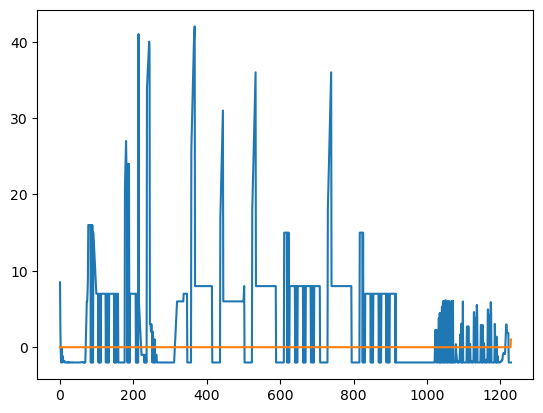

1.0
-1.0


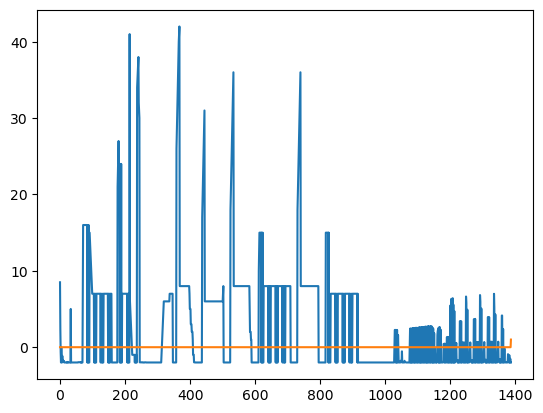

In [7]:
for data in dataset:
    print(np.max(data['actions']))
    print(np.min(data['actions']))
    plt.plot(data['rewards'])
    plt.plot(data['terminals'])
    plt.show()

In [ ]:
np.max( np.load('actionlist.npy'))

In [ ]:
np.max(data['actions'])

In [ ]:
plt.imshow(env.f_decay)

In [ ]:
env.max_step

In [ ]:
#!cp drone_dataset.pkl online-dt/data/

In [ ]:
terminals

In [ ]:
args

In [ ]:
env = make_pytorch_env(args)


In [ ]:
env.max_step

In [ ]:
args.

In [ ]:
def generate_unc_map_blobs(h_field,w_field, beta_decay):

	#rng = default_rng(seed=seedval)
	rng = default_rng()

	# create random noise image
	noise = rng.integers(0, 255, (h_field,w_field), np.uint8, True)

	# blur the noise image to control the size
	blur = cv2.GaussianBlur(noise, (0,0), sigmaX=15, sigmaY=15, borderType = cv2.BORDER_DEFAULT)

	# stretch the blurred image to full dynamic range
	stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)

	# threshold stretched image to control the size
	thresh = cv2.threshold(stretch, 175, 255, cv2.THRESH_BINARY)[1]

	# apply morphology open and close to smooth out and make 3 channels
	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
	mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
	mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

	# show results
	mask = np.where(mask==255,1,beta_decay)
    
	equals_one = np.sum(np.sum(mask==1))
	diff_one = np.sum(np.sum(mask!=1))
    
	if equals_one<=diff_one:
		mask = np.where(mask==beta_decay,1,beta_decay)
    
	return mask

In [ ]:
from numpy.random import default_rng
import skimage.exposure

a = generate_unc_map_blobs(100,100,0.7)
plt.imshow(a)

In [ ]:
a

In [ ]:
equals_1

In [ ]:
(a!=1)

In [ ]:
diff_one